In [7]:
import sys
sys.path.append("../src")

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
import umap
from sklearn.model_selection import train_test_split

from lib.pipeline import get_preprocessors, reduce_dimension, detect_outliers

from lib.i_o import read_csv

## Preprocessing

In [8]:
df_x_train = read_csv("X_train.csv", "../data/").drop(columns="id")
df_y_train = read_csv("y_train.csv", "../data/").drop(columns="id")

Read data from ../data/X_train.csv
Read data from ../data/y_train.csv


In [9]:
df_x_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x822,x823,x824,x825,x826,x827,x828,x829,x830,x831
0,14168.823171,10514.380717,3316.149698,94230.695124,102.386606,92.677127,11108.748199,10866.505510,10837.622093,10.227734,...,NaN,12352.094085,846.014651,105.132144,102.112809,2090.004260,2.691845,1234.374109,1000.784475,9285.751272
1,17757.037554,NaN,4101.016273,92959.527633,NaN,99.855168,10013.959449,10826.607494,10076.101597,11.436970,...,NaN,16198.071494,776.084467,106.385590,103.472030,2474.051881,2.287976,NaN,1012.626705,11750.284764
2,14226.656663,11029.642499,NaN,124055.600561,100.542483,92.860892,NaN,10492.342868,NaN,10.810076,...,10329.704431,13976.063780,737.040332,103.671234,109.458246,2656.083281,2.843706,888.353607,1048.810385,9553.922728
3,8766.012436,7384.202998,2147.308418,100157.719990,104.855061,101.929026,10050.049932,10499.521099,10525.030989,10.092109,...,10008.251395,6212.127347,329.044233,105.084488,104.858546,1097.785204,2.732257,927.752967,1048.357330,NaN
4,13801.016418,13269.493652,3408.316953,92048.527786,103.759758,95.789235,9667.353978,10750.783106,10618.800750,12.006773,...,10095.782015,13772.061493,NaN,NaN,100.369834,2693.053231,2.702908,1471.354073,1071.284484,9423.533063


In [10]:
# Split the data
X_train_val, X_test, y_train_val, y_test = train_test_split(df_x_train, df_y_train, test_size=0.15, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=1) 

In [11]:
print(f"#Features: {df_x_train.shape[1]}\n#observations: {df_x_train.shape[0]}")

#Features: 832
#observations: 1212


In [12]:
from sklearn import preprocessing
from sklearn.impute import SimpleImputer, KNNImputer
feature_scaler = preprocessing.RobustScaler().fit(X_train)
X_train_scaled = pd.DataFrame(feature_scaler.transform(X_train))

feature_imputer = KNNImputer(missing_values=np.nan, weights="distance").fit(X_train_scaled)
X_train_imputed = pd.DataFrame(feature_imputer.transform(X_train_scaled))

y_scaler = preprocessing.RobustScaler().fit(y_train)
y_train_scaled = pd.DataFrame(y_scaler.transform(y_train))
y_scaled_imputer = KNNImputer(missing_values=np.nan, weights="distance").fit(y_train_scaled)
y_imputer = KNNImputer(missing_values=np.nan, weights="distance").fit(y_train)
y_train_scaled_imputed = pd.DataFrame(y_scaled_imputer.transform(y_train_scaled))
y_train_imputed = pd.DataFrame(y_imputer.transform(y_train))

In [13]:
X_train_imputed.head()

,0,1,2,3,4,5,6,7,8,9,...,822,823,824,825,826,827,828,829,830,831
0,0.753935,-0.508197,-0.241217,0.332667,-0.295885,-0.619500,0.824783,-0.235241,-0.618928,0.667615,...,-0.045697,0.267282,0.672470,-0.402731,-1.025642,0.715393,-0.341415,-0.041119,-0.817961,-0.663576
1,-0.311504,-0.967523,-0.695675,0.525044,0.523429,-1.495459,-1.159030,0.200787,0.330194,-0.815643,...,-0.088430,-0.650138,-0.382387,-0.804350,-0.688725,0.177733,0.643052,0.131973,-0.950224,0.715374
2,0.181911,0.071630,-0.761332,0.734662,0.255576,-1.591970,-0.226300,0.498284,-0.299950,-1.559003,...,-1.365657,-0.047609,-0.945193,-0.318193,0.374489,0.724512,0.411854,-0.452478,-0.059310,0.361108
3,0.519243,0.058788,1.981992,0.856846,0.220920,1.929729,-0.670960,-0.251344,-0.138205,1.564303,...,0.215346,0.929478,0.610787,0.855131,0.441871,0.598463,-0.053654,1.266091,0.361550,0.394538
4,0.326490,0.735942,0.557099,0.303802,0.647149,-0.476441,-0.622404,-0.074809,0.685236,0.045622,...,-0.472905,0.726765,-1.340824,-0.000072,0.291784,0.718355,0.006252,0.512985,-0.333899,-0.287697


In [14]:
# Remove outliers
num_observation_before = X_train_imputed.shape[0]

# X_train_inliers = X_train_imputed[X_train_imputed['is_inlier']].drop(columns=['is_inlier'])
# y_train_inliers = y_train_imputed[X_train_imputed['is_inlier']]

# No outlier removal
X_train_inliers = X_train_imputed
y_train_inliers = y_train_imputed

num_observation_after = X_train_inliers.shape[0]
print(f"#Outliers removed: {num_observation_before - num_observation_after}")

#Outliers removed: 0


In [15]:
# Prepare validation set
X_val_scaled = feature_scaler.transform(X_val)
X_val_imputed = feature_imputer.transform(X_val_scaled)
y_val_imputed = y_imputer.transform(y_val)

X_val_scaled.shape

(155, 832)

In [16]:
pd.DataFrame(X_val_imputed).head()

,0,1,2,3,4,5,6,7,8,9,...,822,823,824,825,826,827,828,829,830,831
0,0.598315,-0.369891,-0.301459,1.499899,0.744178,0.590331,0.157772,-0.618750,-0.189304,0.089605,...,0.273699,0.207212,0.553760,-0.450498,0.044669,0.395343,-0.311170,-0.417979,-0.125990,0.246327
1,1.028287,0.354863,0.237556,-0.099442,0.510996,0.716111,-0.018175,0.719014,0.846400,0.331800,...,-0.704880,0.479464,-0.431005,-0.193266,0.530963,1.563002,-0.287511,-0.367720,0.862000,-0.002443
2,1.393176,0.781744,0.242804,-0.293579,-0.576562,-0.266954,-0.985080,0.473554,-0.849690,-0.117892,...,0.742842,0.361695,0.620908,0.636031,-0.094609,0.572193,-0.261774,-0.217021,0.559840,-0.152908
3,-0.721681,0.475414,0.182536,0.626322,-0.066166,-0.285571,0.406140,-0.253475,-0.009020,1.045911,...,-0.727014,-0.138486,0.347095,0.365304,-0.841309,0.393855,0.160740,0.953889,0.913340,1.415471
4,0.357231,0.249859,0.512986,0.070424,-0.173431,-0.410201,-0.407829,0.661011,0.756683,-0.142376,...,1.141696,-0.417805,-0.444143,0.502788,-1.015679,-0.623139,-0.874393,0.674095,0.230185,0.033976


## Model training

In [17]:
# from xgboost import XGBRegressor

# model = XGBRegressor(n_estimators=20, max_depth=2, device="cuda", subsample=0.6, colsample_bytree=0.5)

In [18]:
# Train variable selector
from sklearn.feature_selection import SelectFromModel

selector_model = GradientBoostingRegressor(random_state=0,n_estimators=100, loss="huber")
# selector_model = model
var_selector = SelectFromModel(estimator=selector_model, threshold="2*mean").fit(X_train_inliers, np.array(y_train_inliers).ravel())
print(f"Threshold for selecting features: {round(var_selector.threshold_, 7)}")

Threshold for selecting features: 0.0024038


In [19]:
# Remove features
dim_before = X_train_inliers.shape[1]
X_train_selected = var_selector.transform(X_train_inliers)
X_val_selected = var_selector.transform(X_val_imputed)

print(f"#Removed feature: {dim_before - X_train_selected.shape[1]}")

#Removed feature: 781


## Input cell below 

In [20]:
# WITHOUT variable selection
# _train = X_train_inliers
# _val = X_val_imputed

# WITH variable selection
_train = X_train_selected
_val = X_val_selected

In [21]:
# Train regression model
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

reg_model = GradientBoostingRegressor(random_state=0, loss="huber", n_estimators=100)
# reg_model = model

reg_model.fit(_train, np.array(y_train_inliers).ravel())
print(f"#features used for training: {_train.shape[1]}")

#features used for training: 51


In [22]:
# Make predictions
train_pred = reg_model.predict(_train)
val_pred = reg_model.predict(_val)

print(f"#features used for prediction: {_train.shape[1]}")

#features used for prediction: 51


## Analysis of model performance

In [23]:
# Compute residuals
# for training data
y_train_inliers_reset_index = pd.Series(y_train_inliers.reset_index()[0]) 
residuals_train = y_train_inliers_reset_index - pd.Series(train_pred)
squared_residuals_train = residuals_train**2

# for val data
y_val_reset_index = pd.Series(y_val_imputed.ravel()) 
residuals_val = y_val_reset_index - pd.Series(val_pred)
squared_residuals_val = residuals_val**2

In [24]:
df_residuals_train = pd.DataFrame({
    'residuals': residuals_train.apply(lambda x: abs(x))
    , 'y': y_train_inliers_reset_index
    , 'pred': train_pred
})

df_residuals_val = pd.DataFrame({
    'residuals': residuals_val.apply(lambda x: abs(x))
    , 'y': y_val_reset_index
    , 'pred': val_pred
})

In [25]:
df_residuals_train.groupby('y').apply(lambda x: pd.Series({
    'cnt': x['residuals'].shape[0]
    , 'mean_residuals': x['residuals'].mean()
    , 'std_residuals': x['residuals'].std()
    , 'mean_pred': x['pred'].mean()
    , 'std_pred': x['pred'].std()
})).sort_values(by='mean_residuals', ascending=False)

,cnt,mean_residuals,std_residuals,mean_pred,std_pred
y,,,,,
93.0,1.0,30.712266,NaN,62.287734,NaN
96.0,1.0,21.590926,NaN,74.409074,NaN
95.0,1.0,16.274011,NaN,78.725989,NaN
97.0,1.0,9.722838,NaN,87.277162,NaN
43.0,1.0,8.596599,NaN,51.596599,NaN
48.0,5.0,8.480805,2.295822,56.480805,2.295822
45.0,4.0,8.105301,1.019582,53.105301,1.019582
47.0,1.0,6.225700,NaN,53.225700,NaN
49.0,7.0,6.085931,4.304074,55.085931,4.304074


In [26]:
df_residuals_val.groupby('y').apply(lambda x: pd.Series({
    'cnt': x['residuals'].shape[0]
    , 'mean_residuals': x['residuals'].mean()
    , 'std_residuals': x['residuals'].std()
    , 'mean_pred': x['pred'].mean()
    , 'std_pred': x['pred'].std()
})).sort_values(by='mean_residuals', ascending=False)

,cnt,mean_residuals,std_residuals,mean_pred,std_pred
y,,,,,
89.0,1.0,25.262457,NaN,63.737543,NaN
50.0,2.0,18.351825,11.780615,68.351825,11.780615
94.0,1.0,14.243723,NaN,79.756277,NaN
95.0,1.0,13.258170,NaN,81.741830,NaN
53.0,2.0,9.730011,5.591369,62.730011,5.591369
87.0,3.0,9.372628,8.948647,78.005569,9.513035
85.0,1.0,8.982626,NaN,76.017374,NaN
49.0,1.0,8.221900,NaN,57.221900,NaN
82.0,3.0,7.664974,4.243898,74.335026,4.243898


count    51.000000
mean      0.019608
std       0.043534
min       0.003400
25%       0.006514
50%       0.009385
75%       0.014472
max       0.313023
Name: 0, dtype: float64

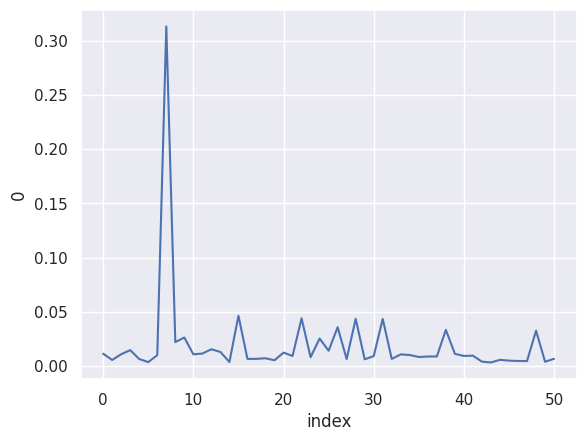

In [27]:
df_feature_importance = pd.DataFrame(reg_model.feature_importances_).reset_index()
sns.lineplot(data=df_feature_importance, x='index', y=0)
df_feature_importance[0].describe()

In [28]:
val_sorted_index = (y_val.reset_index()['y'] - pd.Series(val_pred)).apply(lambda x: abs(x)).sort_values(ascending=False).index
y_val_sorted = y_val.reset_index()['y'][val_sorted_index]

/home/bjn/PycharmProjects/predicting_age/venv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: ylabel='y'>

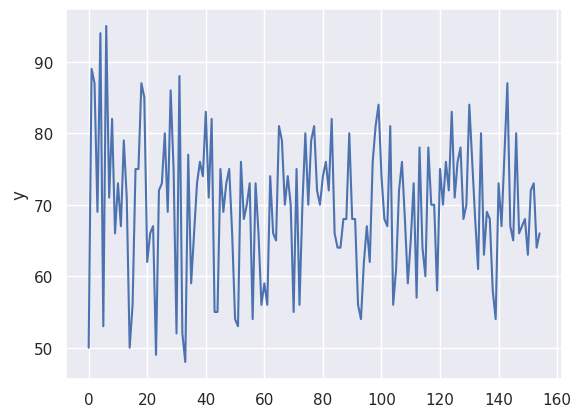

In [29]:
sns.lineplot(range(0, y_val_sorted.shape[0]), y_val_sorted)

In [30]:
normalized_residuals = pd.Series((squared_residuals_train / squared_residuals_train.sum())).sort_values(ascending=False)

/home/bjn/PycharmProjects/predicting_age/venv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: ylabel='0'>

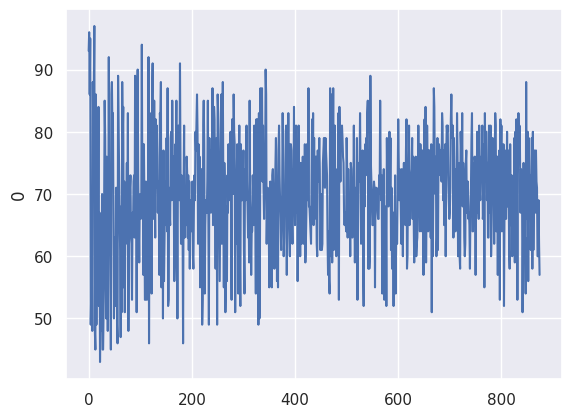

In [31]:
sns.lineplot(range(0, y_train_inliers_reset_index.shape[0]), y_train_inliers_reset_index.loc[normalized_residuals.index])

In [32]:
above = 10

theor_perc = round(above/normalized_residuals.shape[0], 2)
actual_perc = round(normalized_residuals.head(10).sum(), 2)
print(f"Contribution of top {above} theoretical / actual: {theor_perc} / {actual_perc}")

Contribution of top 10 theoretical / actual: 0.01 / 0.26


/home/bjn/PycharmProjects/predicting_age/venv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: >

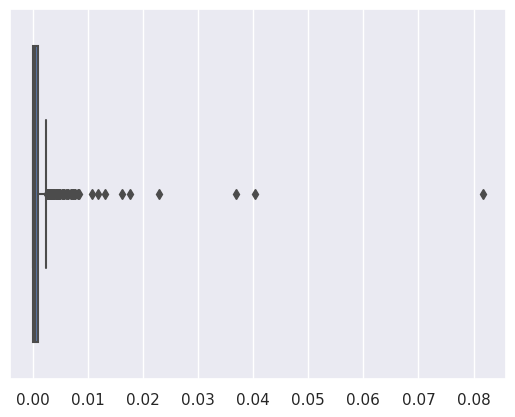

In [33]:
sns.boxplot(squared_residuals_train / squared_residuals_train.sum())

In [34]:
validation_score = round(r2_score(y_val, val_pred), 3)
train_score = round(r2_score(y_train_inliers, train_pred), 3)
print(f"Training score {train_score}")
print(f"Validation score {validation_score}")

Training score 0.858
Validation score 0.534


## Pipeline

In [35]:
# subsample 0.7, n_estimators: 75, max_features 0.9

In [82]:
# Rewrite preprocessing and model as a sklearn pipeline
from sklearn.pipeline import Pipeline           
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
from time import time, sleep

start_t = time()

selector_model = GradientBoostingRegressor(
    random_state=0,
    n_estimators=70,
    subsample=0.7,
    max_features=0.9,
    learning_rate=0.06
)

pipe = Pipeline([
('scaler', preprocessing.RobustScaler()),
('imputer', KNNImputer()),
('feature_selector', SelectFromModel(selector_model)),
('regression_model', GradientBoostingRegressor())
])

pipe.set_params(
    imputer__missing_values=np.nan, 
    imputer__weights="distance",
    feature_selector__threshold="2*mean",
)

# Set grid / solution space
n_max_features_range = [0.9] #np.arange(0.7, 0.98, 0.025)
n_estim_range =  np.arange(30, 90, 5) # 50 - 90
n_subsample_range = [0.91] #np.arange(0.6, 1, 0.01) #0.6 - 0.9
learning_rate_range = np.arange(0.01, 0.2, 0.01)


parameters = {
    #'regression_model__subsample': n_subsample_range, 
    'regression_model__n_estimators':n_estim_range
    #'regression_model__max_features': n_max_features_range,
    #'regression_model__learning_rate': learning_rate_range
}

# Train grided model
grided_model = GridSearchCV(pipe, parameters, scoring='r2', n_jobs=-1, cv=5, return_train_score=True)
grided_model.fit(X_train, np.array(y_train).ravel())

print(f"Elapsed time {round((time()-start_t)/60, 3)} min")

Elapsed time 3.412 min


In [83]:
# Assemble evaluation data into a data frame
df_cv_results = pd.DataFrame(grided_model.cv_results_)
df_model_params = df_cv_results.apply(lambda x: pd.Series(x["params"]), axis=1)
df_cv_results[df_model_params.columns] = df_model_params
df_cv_results.sort_values(by="rank_test_score", inplace=True)

In [84]:
grided_model.cv_results_["params"]

[{'regression_model__n_estimators': 30},
 {'regression_model__n_estimators': 35},
 {'regression_model__n_estimators': 40},
 {'regression_model__n_estimators': 45},
 {'regression_model__n_estimators': 50},
 {'regression_model__n_estimators': 55},
 {'regression_model__n_estimators': 60},
 {'regression_model__n_estimators': 65},
 {'regression_model__n_estimators': 70},
 {'regression_model__n_estimators': 75},
 {'regression_model__n_estimators': 80},
 {'regression_model__n_estimators': 85}]

In [88]:
df_cv_results[[
    'mean_test_score', 
    'mean_train_score', 
    'std_test_score',
    'std_train_score'
    , 'regression_model__n_estimators'
    #, 'regression_model__max_features'
    #, 'regression_model__subsample'
    #, 'regression_model__learning_rate'
]].head(20)

,mean_test_score,mean_train_score,std_test_score,std_train_score,regression_model__n_estimators
1,0.473498,0.767251,0.039890,0.009130,35
0,0.468406,0.742352,0.045569,0.009881,30
2,0.467538,0.789951,0.045899,0.008629,40
4,0.466968,0.823214,0.047275,0.006913,50
11,0.465986,0.892232,0.053280,0.005513,85
9,0.465415,0.876177,0.058234,0.005220,75
10,0.463504,0.885058,0.055911,0.004727,80
3,0.463406,0.808122,0.046862,0.008265,45
5,0.463351,0.837287,0.054079,0.006266,55
8,0.463200,0.867271,0.052675,0.005035,70


In [79]:
df_cv_results[[
    'mean_test_score', 
    'mean_train_score', 
    'std_test_score',
    'std_train_score',
    'regression_model__max_features', 
    'regression_model__n_estimators',
    'regression_model__subsample',
    'regression_model__learning_rate'
]].loc[18]

mean_test_score                     0.488885
mean_train_score                    0.852114
std_test_score                      0.037214
std_train_score                     0.003945
regression_model__max_features      0.900000
regression_model__n_estimators     35.000000
regression_model__subsample         0.910000
regression_model__learning_rate     0.190000
Name: 18, dtype: float64

<Axes: xlabel='regression_model__n_estimators', ylabel='mean_test_score'>

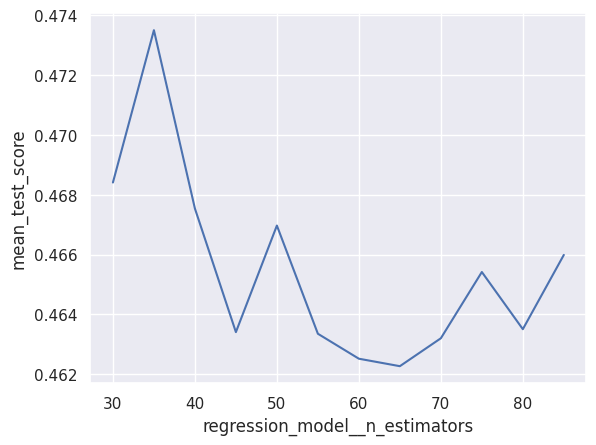

In [89]:
sns.lineplot(data=df_cv_results, x='regression_model__n_estimators', y='mean_test_score')

<Axes: xlabel='regression_model__n_estimators', ylabel='mean_train_score'>

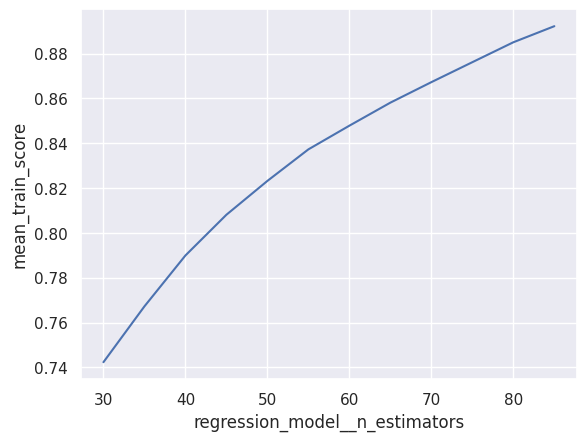

In [91]:
sns.lineplot(data=df_cv_results, x='regression_model__n_estimators', y='mean_train_score')

<Axes: xlabel='regression_model__learning_rate', ylabel='mean_test_score'>

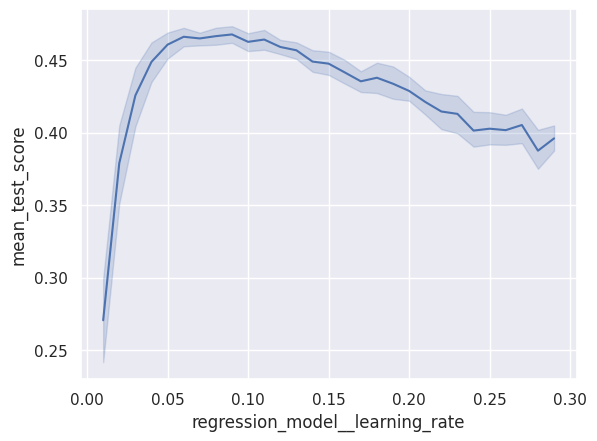

In [79]:
sns.lineplot(data=df_cv_results, x='regression_model__learning_rate', y='mean_test_score')

<Axes: xlabel='regression_model__max_features', ylabel='mean_test_score'>

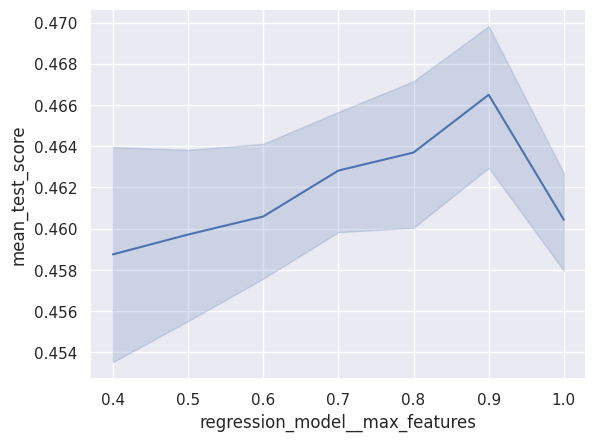

In [182]:
sns.lineplot(data=df_cv_results, x='regression_model__max_features', y='mean_test_score')

In [ ]:
train_pred = grided_model.predict(X_train)
val_pred = grided_model.predict(X_val)

In [ ]:
validation_score = round(r2_score(y_val, val_pred), 3)
train_score = round(r2_score(y_train_inliers, train_pred), 3)
print(f"Training score {train_score}")
print(f"Validation score {validation_score}")